In [1]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install opencv-python
!pip install matplotlib


import tensorflow as tf
import numpy as np
import imghdr
import json
import cv2
import os

from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
     ---------------------------------------- 1.7/1.7 MB 7.2 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.11.2 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.11.0 which is incompatible.


     ---------------------------------------- 5.9/5.9 MB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 10.7 MB/s eta 0:00:00
     -------------------------------------- 438.7/438.7 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [2]:
#avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
#Set training data directory    
data_dir = 'training_data'

In [10]:
#define required image extensions
image_exts = ['jpeg','jpg','bmp','png']

#remove unwanted images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list training_data\whatsappnotes\Engineering-Mathematics-handwritten-notes-pdf-480x319.png
Image not in ext list training_data\whatsappnotes\Engineering-Mathematics-handwritten-notes-pdf.png
Image not in ext list training_data\whatsappnotes\ith-Answers-Solutions-Handwritten-Lecture-Notes-for-Gate-Mechanical-Entrance.jpg
Image not in ext list training_data\whatsappnotes\Made-Easy-ME-EE-CE-Preliminary-Stage-1-GS-Aptitude-g.jpg
Image not in ext list training_data\whatsappspam\4b-376f-4a97-98c1-b820660c3ba22FGood_Morning_Gud_Night_Messages_live_Updates.jpg
Image not in ext list training_data\whatsappspam\babe804f90170d84f5cfb977853aa9009a2358fdb78536c5725e350ccdbe16cb.webp
Image not in ext list training_data\whatsappspam\Best-Good-Morning-Images.webp
Image not in ext list training_data\whatsappspam\good-morning-image-002.jpg
Image not in ext list training_data\whatsappspam\good-morning-image-01-8oct.jpg


In [11]:
#read and create a dataset of images with labels            
data = tf.keras.utils.image_dataset_from_directory('training_data')

Found 444 files belonging to 2 classes.


In [12]:
#access images as numpy array
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [13]:
# Generate a unique folder name using the current time and date to save model files
now = datetime.now().strftime("%d.%m.%Y %H%M%S")
folder_name = f"{now}-train_results"
folder_path = os.path.join(folder_name)
os.makedirs(folder_path, exist_ok=True)

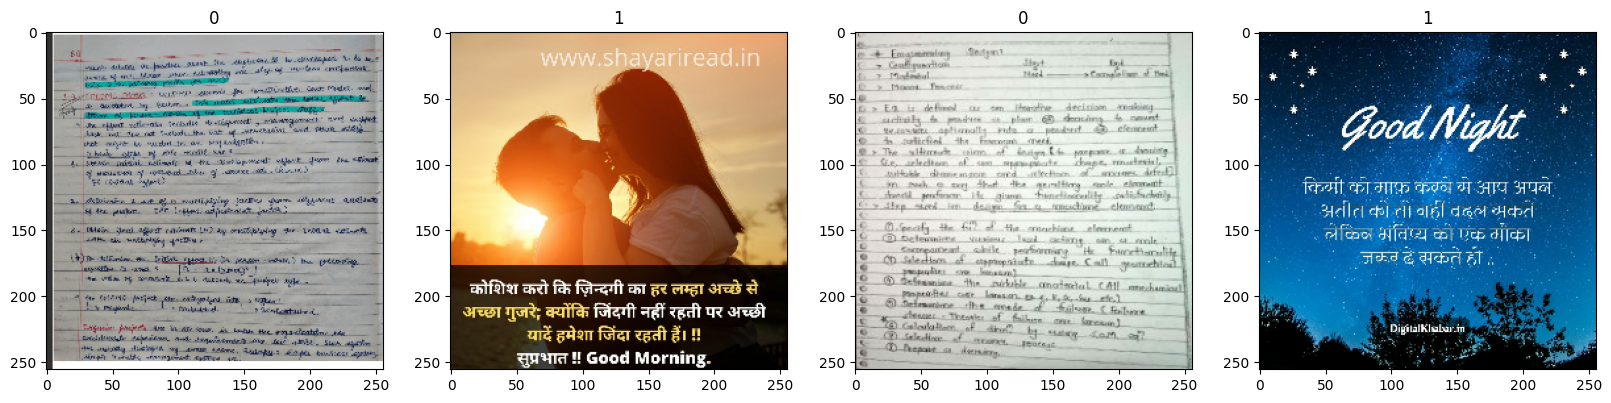

In [14]:
#create batch of image data and labels
batch[0]
batch[1]
    
# Plot the batch results
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])    

# Save the plot figure to a file
fig.savefig(os.path.join(folder_path, 'batch_result.jpg'))


In [15]:
data = data.map(lambda x,y: (x/255, y))
data = tf.keras.utils.image_dataset_from_directory('training_data')

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 444 files belonging to 2 classes.


In [16]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [17]:
# Get current date and time
now = datetime.now()

# Save model summary to a text file
with open(f'{folder_name}/summary.txt', 'w') as f:
    f.write(f'Summary generated on {now}\n\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [18]:
logdir = os.path.join(folder_path, 'logs')

# Check if the logs directory already exists
if not os.path.exists(logdir):
  # Create the logs directory if it does not exist
  os.makedirs(logdir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

hist.history


  

with open(os.path.join(folder_path, 'history.json'), 'w') as f:
    json.dump(hist.history, f)

Epoch 1/20
9/9 [==============================] - 8s 211ms/step - loss: 261.3831 - accuracy: 0.5903 - val_loss: 0.2729 - val_accuracy: 0.9062
Epoch 2/20
9/9 [==============================] - 2s 224ms/step - loss: 0.3558 - accuracy: 0.9271 - val_loss: 0.1098 - val_accuracy: 0.9375
Epoch 3/20
9/9 [==============================] - 2s 193ms/step - loss: 0.4621 - accuracy: 0.8715 - val_loss: 0.3668 - val_accuracy: 0.9531
Epoch 4/20
9/9 [==============================] - 2s 194ms/step - loss: 0.8426 - accuracy: 0.9167 - val_loss: 0.6955 - val_accuracy: 0.7031
Epoch 5/20
9/9 [==============================] - 2s 181ms/step - loss: 0.5467 - accuracy: 0.7396 - val_loss: 0.3329 - val_accuracy: 0.8438
Epoch 6/20
9/9 [==============================] - 2s 181ms/step - loss: 0.3221 - accuracy: 0.8715 - val_loss: 0.4200 - val_accuracy: 0.7812
Epoch 7/20
9/9 [==============================] - 2s 185ms/step - loss: 0.2395 - accuracy: 0.8924 - val_loss: 0.2081 - val_accuracy: 0.8906
Epoch 8/20
9/9 [==

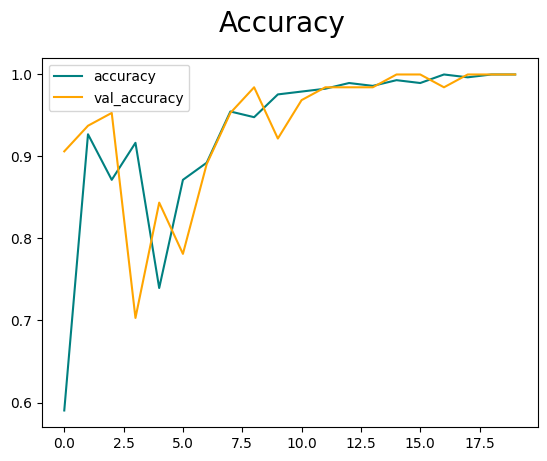

In [19]:

# Plot the accuracy chart
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")

# Save the figure to a file
fig.savefig(os.path.join(folder_path, 'accuracy_chart.jpg'))

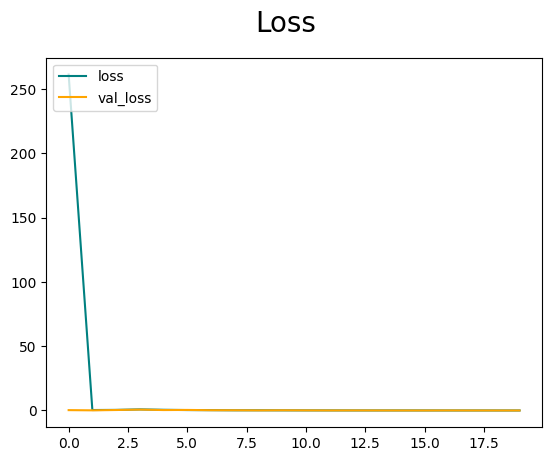

In [20]:

# Plot the loss chart
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")

# Save the figure to a file

fig.savefig(os.path.join(folder_path, 'loss_chart.jpg'))

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')    


1/1 [==============================] - 0s 126ms/step
Precision:1.0, Recall:1.0, Accuracy:1.0


In [22]:

# Open the file in write mode
with open(os.path.join(folder_path, 'results.txt'), 'w') as f:
    # Write the results to the file
    f.write(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

In [23]:

model_name_input = input('Enter the model name to save: ')
model_name = f'{model_name_input}_model.h5'
model.save(os.path.join(folder_path, model_name))


Enter the model name to save: wspamvswotesnew
